## Imports and settings

In [2]:
import src
import keras.backend as K
from os import *
import numpy as np
import sys
import re
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')
#forces CPU usage
environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
environ["CUDA_VISIBLE_DEVICES"] = "-1" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9308214746436472431
]


______________________________________-
## Data preprocessing

### Rain measurements
Measurements are downloaded from the DWD (German weather service) open data server: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/__<br>
I'm working with the data of August 2010 (based on [this](https://tradingeconomics.com/germany/precipitation)), so I have downloaded this: __ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/2010/RW-201008.tar__<br>
_DWD manual:_<br>
__ftp://ftp-cdc.dwd.de/pub/CDC/grids_germany/hourly/radolan/historical/asc/BESCHREIBUNG_gridsgermany_hourly_radolan_historical_asc_de.pdf__<br><br>
This contains radar maps recorded in every hour. Each map has a resolution of $900\times900$ pixels and each pixel corresponds to an $1\,km\times1\,km$ area in reality. Pixel values are the precipitation height in $0.1\,mm$.
Below I'm importing the data of this as a series of numpy arrays and plot them to see the acual radar map. The _sys.path[0]_ is the path on my computer and it can be different for you.

In [3]:
#the paths are probably different for you
w_dir = Dataset(sys.path[0]+'/wind_direction/DD_201008_CF.nc')  # direction DD
w_vel = Dataset(sys.path[0]+'/wind_speed/FF_201008_CF.nc')  # velocity FF
rho = Dataset(sys.path[0]+"/rain_density/rho.nc")

In [26]:
data = generate_tempoGAN_datasets(rho["field"], w_dir["DD"], n=10, length=4, size=64, split=(6,2,2), normalize=True)

(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)
(4, 64, 64, 3)


KeyboardInterrupt: 

In [5]:
train = data["train"]
xval = data["xval"]
test = data["test"]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


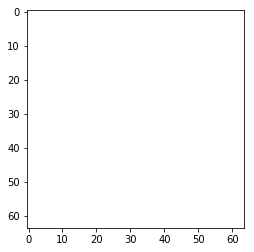

In [19]:
plt.imshow(train[5,3,:,:,0])

In [25]:
def generate_tempoGAN_datasets(rain_density, wind_dir, n=10, length=2, size=64, split=None, normalize=False):
    """
    Splits input array into training, cross validation and test sets.
    :param rain_density: .nc file containing interpolated rain maps on wind grid. A masked np array of shape
     744*938*720.
    :param wind_dir: same as the rain but these are the wind maps on the same grid. They have the same shape. The
    vx and vy channels are calculated from this.
    :param n: int, total number of data instances to make
    :param length: int, number of consecutive frames on time axis to cut. It cuts length frames from all three channels.
    (rho, vx, vy)
    :param size: int, height and width in pixels of each frame
    :param split: list or np array of either floats between 0 and 1 or positive integers. Set to None by deafult
    which means no splitting, just return all instances in one set.
    :param normalize: boolean, if true, the rain maps will be normalized between [0,1]. They are simply divided by the
    max pixel value in the series. (Wind is always between [-1,1])
    :return: 3D np array, either one dataset of smaller image frames or three datasets for training,
    cross validating and testing
    """
    time = 743
    h = rain_density[0].shape[0]  # 938
    w = rain_density[0].shape[1]  # 720

    images = np.zeros(
        (n, length, size, size, 3))  # n series, each of size size**2 and rho,vx,vy,future frames as channels
    for i in range(n):
        #src.update_output(f"[{i+1}/{n}]")
        # draw 3 random numbers for map number and idx of top left pixel of window
        valid = 0
        while not valid:
            anchor = (np.random.randint(0, time - 2), np.random.randint(0, h - size), np.random.randint(0, w - size))
            image = np.empty((length, size, size, 3))
            for j in range(length):
                r = rain_density[anchor[0] + j]
                x = -np.flip(np.sin(np.deg2rad(wind_dir[anchor[0] + 1 + j])), axis=0)
                y = -np.flip(np.cos(np.deg2rad(wind_dir[anchor[0] + 1 + j])), axis=0)
                image[j, :, :, 0] = r[anchor[1]:anchor[1] + size, anchor[2]:anchor[2] + size].filled(np.nan)
                image[j, :, :, 1] = x[anchor[1]:anchor[1] + size, anchor[2]:anchor[2] + size].filled(np.nan)
                image[j, :, :, 2] = y[anchor[1]:anchor[1] + size, anchor[2]:anchor[2] + size].filled(np.nan)
            # first channel is the current frame, the next two are the wind x and y components where the index is shifted by 1
            # because the rain dates are in xx:50 resolution but the wind is in xx:00. The next channels are the next rain fields
            # to be predicted
            valid = valid_image(image)
        images[i] += image

    if normalize:  # to [0,1] only for rain
        images[:, :, :, :, 0] = np.array([s[:, :, :, 0] / s[:, :, :, 0].max() for s in images])
    txt = f"Shape of data: {np.shape(images)}"
    if split is not None:  # split
        if all((r <= 1) & (r >= 0) for r in split):
            assert (sum(split) == 1), "Split values must sum up to 1."
            train = images[:int(n * split[0])]
            xval = images[int(n * split[0]):int(n * (split[0] + split[1]))]
            test = images[int(n * (split[0] + split[1])):]
        elif all(isinstance(r, int) for r in split):
            train = images[:int(n * split[0] / sum(split))]
            xval = images[int(n * split[0] / sum(split)):int(n * (split[0] + split[1]) / sum(split))]
            test = images[int(n * (split[0] + split[1]) / sum(split)):]
        else:
            sys.exit("All split values must be either fractions for percentages or integers.")

        txt = txt + f"\n\nTraining set: {np.shape(train)}\nValidation set: {np.shape(xval)}\nTest set: {np.shape(test)}"
        #src.update_output(txt)
        return {"train": train,
                "xval": xval,
                "test": test, }
    else:  # no split
       # src.update_output(txt)
        return images

def valid_image(image):
    """
    Filters out some useless data. In the junk variable several conditions are defined to check on the images.
    Currently it checks the number of different entry values and if 0s or 1s make up 0.75 part of the whole data.
    This throws out the cuts made inside or almost inside the mask region and rainless areas.
    Still can be improved.
    :param image: 3D np array, dimensions are the number of consecutive frames, height and width
    :return: bool, whether the data instance is valid in terms of usability
    """
    if len(np.shape(image)) == 3:  # one channel frames
        junk = [len(set(np.array(frame).flatten()[
                            ~np.isnan(np.array(frame).flatten())])) <= 8 for frame in image]
    else:  # three channel frames
        # frame is a triplet for tempogan images
        # only rain channel
        print(np.shape(image))
        junk = [len(set(np.array(frame[:, :, :, 0]).flatten()[
                            ~np.isnan(np.array(frame[:, :, :, 0]).flatten())])) <= 12 for frame in image]

    junk += [len(np.array(frame).flatten()[
                     np.isnan(np.array(frame).flatten())]) > 0.25 * len(np.array(frame).flatten()) for frame in image]
    return 0 if any(junk) else 1

In [ ]:
train, xval, test = src.load_datasets("5min")

In [ ]:
unet_train     = np.reshape(train[:,0,:,:,:],((train.shape[0],)+train.shape[2:]))
unet_truth     = np.reshape(train[:,1,:,:,:],((train.shape[0],)+train.shape[2:]))
unet_val       = np.reshape(xval[:,0,:,:,:],((xval.shape[0],)+xval.shape[2:]))
unet_val_truth = np.reshape(xval[:,1,:,:,:],((xval.shape[0],)+xval.shape[2:]))
print(unet_train.shape,"\n",unet_truth.shape,"\n",unet_val.shape,"\n",unet_truth.shape)
unet_test      = np.reshape(test[:,0,:,:,:],((test.shape[0],)+test.shape[2:]))
unet_test_truth = np.reshape(test[:,1,:,:,:],((test.shape[0],)+test.shape[2:]))

In [ ]:
plt.imshow(unet_test[0,:,:,0])

In [ ]:
overfit_train = np.reshape(train[5,0,:,:,:],((1,)+train.shape[2:]))
overfit_truth = np.reshape(train[5,1,:,:,:],((1,)+train.shape[2:]))

In [ ]:
%matplotlib inline
src.visualise_data(xval[:,:,:,:,0])

## U-net

In [ ]:
#model2=keras.Sequential()
def unet():
    init       = keras.layers.Input(shape=(64,64,1))
    ConvDown1  = keras.layers.Conv2D(filters=8,kernel_size=(2,2),strides=(1,1),padding="same")(init)
    Lr1        = keras.layers.LeakyReLU(alpha=0.1)(ConvDown1)
    #64
    ConvDown2  = keras.layers.Conv2D(filters=16,kernel_size=(2,2),strides=(2,2),padding="same")(Lr1)
    Lr2        = keras.layers.LeakyReLU(alpha=0.1)(ConvDown2)
    #32
    ConvDown3  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr2)
    Lr3        = keras.layers.LeakyReLU(alpha=0.1)(ConvDown3)
    #16
    ConvDown4  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr3)
    Lr4        = keras.layers.LeakyReLU(alpha=0.1)(ConvDown4)
    #8
    ConvDown5  = keras.layers.Conv2D(filters=32,kernel_size=(2,2),strides=(2,2),padding="same")(Lr4)
    Lr5        = keras.layers.LeakyReLU(alpha=0.1)(ConvDown5)
    #4

    UpSamp1 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr5)
    #8
    merge1  = keras.layers.concatenate([ConvDown4,UpSamp1],axis=-1)#(UpSamp1)
    Conv1   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge1)
    Lr6     = keras.layers.LeakyReLU(alpha=0.1)(Conv1)
    #8
    UpSamp2 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr6)
    #16
    merge2  = keras.layers.concatenate([ConvDown3,UpSamp2],axis=-1)#(UpSamp2)
    Conv2   = keras.layers.Conv2D(filters=32,kernel_size=(4,4),strides=(1,1),padding="same")(merge2)
    Lr7     = keras.layers.LeakyReLU(alpha=0.1)(Conv2)
    #16
    UpSamp3 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr7)

    #32
    Conv3   = keras.layers.Conv2D(filters=16,kernel_size=(4,4),strides=(1,1),padding="same")(UpSamp3)
    Lr8     = keras.layers.LeakyReLU(alpha=0.1)(Conv3)

    UpSamp4 = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last")(Lr8)
    #64
    Conv4   = keras.layers.Conv2D(filters=8,kernel_size=(4,4),strides=(1,1),padding="same")(UpSamp4)
    Lr9     = keras.layers.LeakyReLU(alpha=0.1)(Conv4)
    
    Conv5   = keras.layers.Conv2D(filters=1,kernel_size=(4,4),strides=(1,1),padding="same",activation = 'tanh')(Lr9)
    
    return keras.models.Model(inputs=init, outputs=Conv5)

Discriminator

In [ ]:
#Ds = keras.Sequential()
def spatial_discriminator():
    dropout = 0.5
    init = keras.layers.Input(shape=(64,64,1))
    
    conv1 = keras.layers.Conv2D(filters=4 ,kernel_size=4, strides=2, padding='same')(init)
    relu1 = keras.layers.LeakyReLU(alpha=0.2)(conv1)
    dropout1 = keras.layers.Dropout(dropout)(relu1)
    
    conv2 = keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same')(dropout1)
    relu2 = keras.layers.LeakyReLU(alpha=0.2)(conv2)
    dropout2 = keras.layers.Dropout(dropout)(relu2)
    
    conv3 = keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same')(dropout2)
    relu3 = keras.layers.LeakyReLU(alpha=0.2)(conv3)
    dropout3 = keras.layers.Dropout(dropout)(relu3)
    
    conv4 = keras.layers.Conv2D(filters=32, kernel_size=4, strides=2, padding='same')(dropout3)
    relu4 = keras.layers.LeakyReLU(alpha=0.2)(conv4)
    dropout4 = keras.layers.Dropout(dropout)(relu4)
    
    # Out: 1-dim probability
    flatten = keras.layers.Flatten()(dropout4)
    fcl1 = keras.layers.Dense(1)(flatten)
    sig1 = keras.layers.Activation('sigmoid')(fcl1)
    
    return keras.models.Model(inputs=init, outputs=sig1)

In [ ]:
def temporal_discriminator():
    dropout = 0.5
    init = keras.layers.Input(shape=(2,64,64,3)) # t - 1, t
    advected = np.array(advect(init[0]),init[1])
    
    conv1 = keras.layers.Conv2D(filters=4 ,kernel_size=4, strides=2, padding='same')(advected)
    relu1 = keras.layers.LeakyReLU(alpha=0.2)(conv1)
    dropout1 = keras.layers.Dropout(dropout)(relu1)
    
    conv2 = keras.layers.Conv2D(filters=8, kernel_size=4, strides=2, padding='same')(dropout1)
    relu2 = keras.layers.LeakyReLU(alpha=0.2)(conv2)
    dropout2 = keras.layers.Dropout(dropout)(relu2)
    
    conv3 = keras.layers.Conv2D(filters=16, kernel_size=4, strides=2, padding='same')(dropout2)
    relu3 = keras.layers.LeakyReLU(alpha=0.2)(conv3)
    dropout3 = keras.layers.Dropout(dropout)(relu3)
    
    conv4 = keras.layers.Conv2D(filters=32, kernel_size=4, strides=2, padding='same')(dropout3)
    relu4 = keras.layers.LeakyReLU(alpha=0.2)(conv4)
    dropout4 = keras.layers.Dropout(dropout)(relu4)
    
    # Out: 1-dim probability
    flatten = keras.layers.Flatten()(dropout4)
    fcl1 = keras.layers.Dense(1)(flatten)
    sig1 = keras.layers.Activation('sigmoid')(fcl1)
    
    return keras.models.Model(inputs=init, outputs=sig1)

In [ ]:
def advect(image): # (64,64,3)
    padded = np.pad(image,(0,1),'edge')[:,:,:-1]
    advected = np.empty_like(image)
    advected[:,:,0] = image[:,:,0] + image[:,:,1]*(padded[1:,:,0] - padded[:-1,:,0])[:,:-1] + image[:,:,2]*(padded[:,1:,0] - padded[:,:-1,0])[:-1]
    advected[:,:,1:] = image[:,:,1:]
    return advected

In [ ]:
#modified from source: https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
class GAN():
    def __init__(self):
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.metric = [src.relative_error_tensor]

        d_optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        g_optimizer = keras.optimizers.Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.trainable = True
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=d_optimizer,
            metrics=["accuracy"])
        # Build the generator
        self.generator = self.build_generator()
        #self.generator.compile(loss='mse',
        #    optimizer=g_optimizer,
        #    metrics=self.metric)
        
        # The generator takes a sequence of frames as input and generates the next image in that sequence
        input_img = keras.layers.Input(shape=self.img_shape)
        generated = self.generator(input_img)
        
        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(generated)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.discriminator.trainable = False
        self.combined = keras.models.Model(input_img, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=g_optimizer)


    def build_generator(self,network="U-net"):  
        generator = keras.Sequential()
        if network in ["Unet", "U-net", "unet", "u-net"]:
            return unet()

    def build_discriminator(self, which="s"):
        if which == "s":
            return spatial_discriminator()
        elif which == "t":
            return temporal_discriminator()

    def train(self, epochs, g_epochs=1, d_epochs=1, dataset="5min", batch_size=128):

        # Load the dataset
        train, xval, test = src.load_datasets(dataset=dataset)
        unet_train     = np.reshape(train[:,0,:,:,:],((train.shape[0],)+train.shape[2:]))
        unet_truth     = np.reshape(train[:,1,:,:,:],((train.shape[0],)+train.shape[2:]))
        unet_val       = np.reshape(xval[:,0,:,:,:],((xval.shape[0],)+xval.shape[2:]))
        unet_val_truth = np.reshape(xval[:,1,:,:,:],((xval.shape[0],)+xval.shape[2:]))
        print("Shape of training data: ",unet_train.shape,"\nShape of training truth: ",unet_truth.shape,
        "\nShape of validation data: ",unet_val.shape,"\nShape of validation truth: ",unet_val_truth.shape)
        unet_test      = np.reshape(test[:,0,:,:,:],((test.shape[0],)+test.shape[2:]))
        unet_test_truth = np.reshape(test[:,1,:,:,:],((test.shape[0],)+test.shape[2:]))
        
        # Adversarial ground truths
        real = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        #store losses

        log = {"g_loss":[],
               "d_loss":[],
               "g_metric":[],
               "d_metric":[]}
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            idx = np.random.randint(0, unet_truth.shape[0], batch_size)
            real_imgs = unet_truth[idx]
            training_batch = unet_train[idx]

            # Generate a batch of new images
            generated_imgs = self.generator.predict(training_batch)

            # Train the discriminator
            for ks in range(d_epochs):
                d_loss_real = self.discriminator.train_on_batch(real_imgs, real)
                d_loss_fake = self.discriminator.train_on_batch(generated_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                print(f"    {ks} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}]")
            
            # ---------------------
            #  Train Generator
            # ---------------------

            idx2 = np.random.randint(0, unet_train.shape[0], batch_size)
            training_batch = unet_train[idx2]
            training_truth = unet_truth[idx2]

            # Train the generator (to have the discriminator label samples as real)
            for kg in range(g_epochs):
                g_loss = self.combined.train_on_batch(training_batch, real)

            # Plot the progress
            log["g_loss"].append(g_loss)
            log["d_loss"].append(d_loss[0])
            #log["g_metric"].append(g_loss[1])
            log["d_metric"].append(d_loss[1])
            print(f"\033[1m {epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}]\033[0m"+
                  f"\033[1m[G loss: {g_loss}]\033[0m")#, rel. err.: {g_loss[1]}] \033[0m")

            # If at save interval => save generated image samples
            if epoch in [int(x) for x in np.linspace(0.1,1,10)*epochs]:
                self.sample_images(epoch, unet_test, unet_test_truth)
        return log

    def sample_images(self, epoch, unet_test, unet_test_truth):
        n = 5
        test_batch = unet_test[:n]
        test_truth = unet_test_truth[:n]
        gen_imgs = self.generator.predict(test_batch)

        fig, axs = plt.subplots(n, 3, figsize=(16, 16))
        for i in range(n):
                axs[i,0].imshow(test_batch[i, :,:,0])
                axs[i,0].axis('off')
                axs[i,0].set_title("Frame t")
                axs[i,1].imshow(test_truth[i, :,:,0])
                axs[i,1].axis('off')
                axs[i,1].set_title("Frame t+1")
                axs[i,2].imshow(gen_imgs[i, :,:,0])
                axs[i,2].axis('off')
                axs[i,2].set_title("Prediction t+1")
        fig.savefig("Plots/epoch %d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    gan = GAN()
    log = gan.train(epochs=10, d_epochs=5, batch_size=64)

In [ ]:

f = plt.figure(figsize=(16,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(log["g_loss"],label="Generator loss")
ax.plot(log["d_loss"],label="Discriminator loss")
ax.grid()
ax.legend(loc="best")

ax2.plot(log["g_metric"],label="Generator metric")
ax2.plot(log["d_metric"],label="Discriminator metric")
ax2.grid()
ax2.legend(loc="center right")